# Author : Sheikh Nabil

## Task-7 Stock Market Prediction using Numerical and Textual Analysis

In this task I tried to create a hybrid model for stock performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

Used Stack LSTM

Datasets used :

- Historical stock prices :https://finance.yahoo.com/

- Textual news headlines : https://bit.ly/36fFPI6

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Importing the Numerical dataset and performing Exploratory Analysis

In [2]:
stock_price = pd.read_csv('bsesn.csv')

In [3]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,41340.269531,41649.289062,41328.449219,41626.640625,41626.640625,5300
1,2020-01-03,41634.511719,41636.179688,41348.679688,41464.609375,41464.609375,8900
2,2020-01-06,41378.339844,41378.339844,40613.960938,40676.628906,40676.628906,8700
3,2020-01-07,40983.039062,41230.140625,40727.371094,40869.468750,40869.468750,11900
4,2020-01-08,40574.828125,40866.359375,40476.550781,40817.738281,40817.738281,18200


In [4]:

stock_headlines = pd.read_csv('india-news-headlines.csv')

In [5]:
stock_headlines.head()


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


## Feature Engineering

In [6]:
len(stock_price), len(stock_headlines)

(248, 3650970)

In [7]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

## Stock Price Data

In [8]:

# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-01-02,41626.640625,41340.269531,41649.289062,41328.449219,5300
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700
2020-01-07,40869.468750,40983.039062,41230.140625,40727.371094,11900
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200
...,...,...,...,...,...
2020-12-23,46444.179688,46072.300781,46513.320312,45899.101562,10500
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600


## Stock News Headlines Data


In [9]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


## Combined Stock Data

In [10]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-01-02,41626.640625,41340.269531,41649.289062,41328.449219,5300.0,Horoscope Today; 02 January 2020: Read predict...
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up..."
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0,With captive pics and posts; city shining on s...
2020-01-07,40869.468750,40983.039062,41230.140625,40727.371094,11900.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ..."
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0,"Seems like systematic assault; say students,Co..."
...,...,...,...,...,...,...
2020-12-23,46444.179688,46072.300781,46513.320312,45899.101562,10500.0,"Sawmill in Makarpura GIDC gutted; none hurt,Ci..."
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...


## Calculating Sentiment Scores


In [11]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-01-02,41626.640625,41340.269531,41649.289062,41328.449219,5300.0,Horoscope Today; 02 January 2020: Read predict...,,,,
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up...",,,,
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0,With captive pics and posts; city shining on s...,,,,
2020-01-07,40869.468750,40983.039062,41230.140625,40727.371094,11900.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ...",,,,
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0,"Seems like systematic assault; say students,Co...",,,,


In [12]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-01-02,41626.640625,41340.269531,41649.289062,41328.449219,5300.0,Horoscope Today; 02 January 2020: Read predict...,-0.9997,0.125,0.796,0.079
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up...",-0.9963,0.103,0.805,0.092
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0,With captive pics and posts; city shining on s...,-0.9996,0.104,0.839,0.057
2020-01-07,40869.468750,40983.039062,41230.140625,40727.371094,11900.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ...",-1.0000,0.186,0.745,0.069
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0,"Seems like systematic assault; say students,Co...",-0.9999,0.136,0.799,0.065


## Finalising Stock Data and writing to Disk

In [13]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-01-02,41626.640625,-0.9997,0.125,0.796,0.079,41340.269531,41649.289062,41328.449219,5300.0
2020-01-03,41464.609375,-0.9963,0.103,0.805,0.092,41634.511719,41636.179688,41348.679688,8900.0
2020-01-06,40676.628906,-0.9996,0.104,0.839,0.057,41378.339844,41378.339844,40613.960938,8700.0
2020-01-07,40869.468750,-1.0000,0.186,0.745,0.069,40983.039062,41230.140625,40727.371094,11900.0
2020-01-08,40817.738281,-0.9999,0.136,0.799,0.065,40574.828125,40866.359375,40476.550781,18200.0


In [14]:
# writing the prepared stock_data to disk
stock_data.to_csv('bsesnfinal.csv')

## Reading Stock Data

In [16]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('bsesnfinal.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-01-02,41626.640625,-0.9997,0.125,0.796,0.079,41340.269531,41649.289062,41328.449219,5300.0
2020-01-03,41464.609375,-0.9963,0.103,0.805,0.092,41634.511719,41636.179688,41348.679688,8900.0
2020-01-06,40676.628906,-0.9996,0.104,0.839,0.057,41378.339844,41378.339844,40613.960938,8700.0
2020-01-07,40869.468750,-1.0000,0.186,0.745,0.069,40983.039062,41230.140625,40727.371094,11900.0
2020-01-08,40817.738281,-0.9999,0.136,0.799,0.065,40574.828125,40866.359375,40476.550781,18200.0


## Feature Engineering of Stock Data

In [17]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

     

(248, 9)

In [18]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [19]:

# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,37887.479327,-0.991342,0.127617,0.794948,0.077387,37945.934051,38217.846317,37553.585426,19279.838710
std,4778.783298,0.126812,0.020283,0.025600,0.012236,4750.302629,4631.340824,4873.632848,16416.533977
min,25981.240234,-1.000000,0.076000,0.728000,0.046000,26499.810547,27462.869141,25638.900391,5300.000000
25%,34237.300781,-0.999900,0.114000,0.778000,0.069000,34305.207031,34699.283203,33955.879883,13475.000000
50%,38413.355469,-0.999700,0.128000,0.792500,0.077000,38476.410156,38742.685547,38217.509766,17000.000000
75%,41070.613281,-0.999500,0.140000,0.813000,0.085000,41170.886719,41360.597656,40909.855469,21025.000000
max,47746.218750,0.997400,0.199000,0.867000,0.127000,47789.031250,47807.851562,47361.898438,188300.000000


In [20]:

# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 2020-01-02 to 2020-12-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     248 non-null    float64
 1   compound  248 non-null    float64
 2   negative  248 non-null    float64
 3   neutral   248 non-null    float64
 4   positive  248 non-null    float64
 5   Open      248 non-null    float64
 6   High      248 non-null    float64
 7   Low       248 non-null    float64
 8   Volume    248 non-null    float64
dtypes: float64(9)
memory usage: 19.4+ KB


## EDA of Stock Data

Text(0, 0.5, 'Close Price ($)')

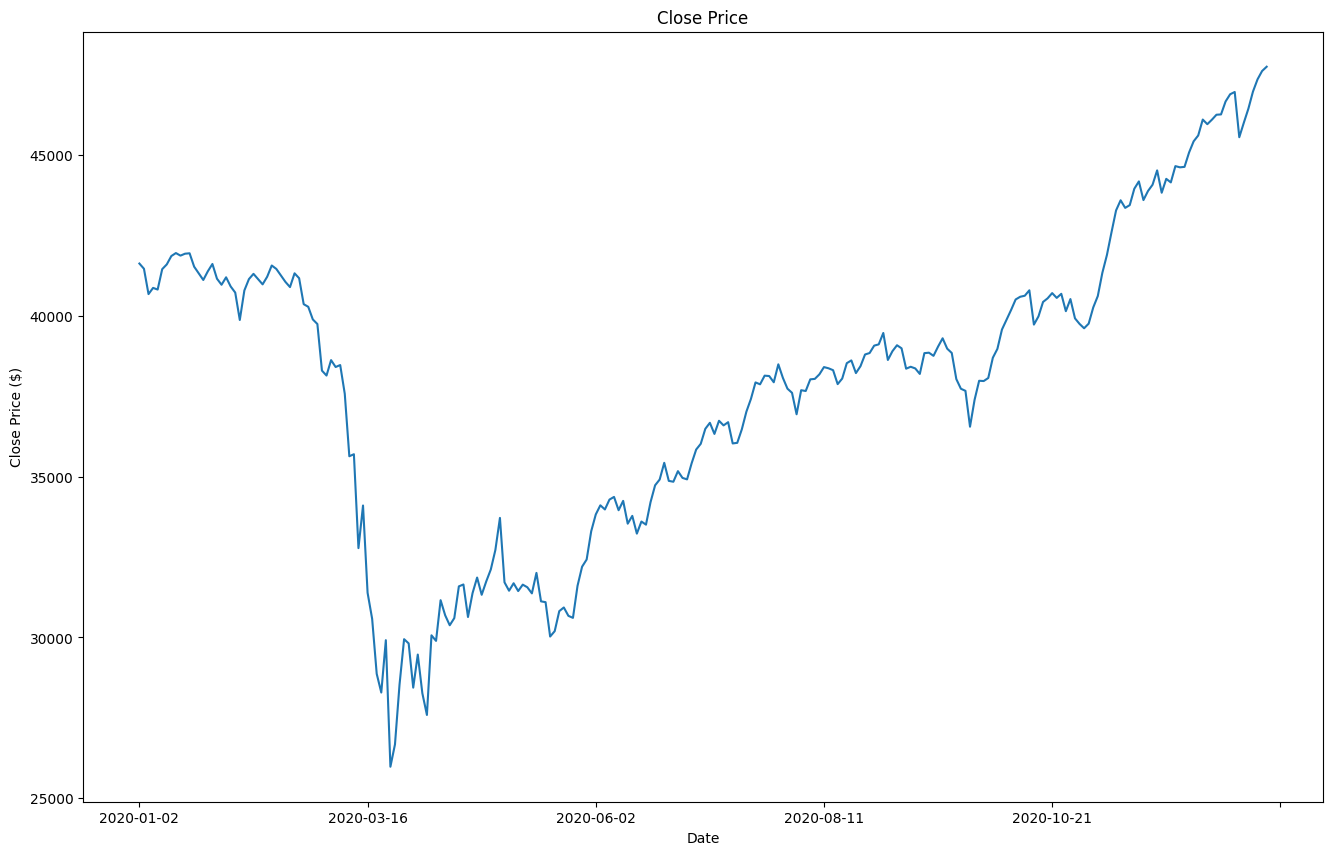

In [21]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [22]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)


,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,41215.308036,-0.999300,0.130571,0.796000,0.073429,41242.265625,41431.077009,41016.933036,10571.428571
2020-01-13,41248.601004,-0.999314,0.133286,0.792857,0.073714,41306.257254,41466.839844,41072.977679,11328.571429
2020-01-14,41318.318080,-0.999829,0.141143,0.788143,0.070714,41341.768415,41517.994420,41133.294643,12071.428571


<Axes: xlabel='Date'>

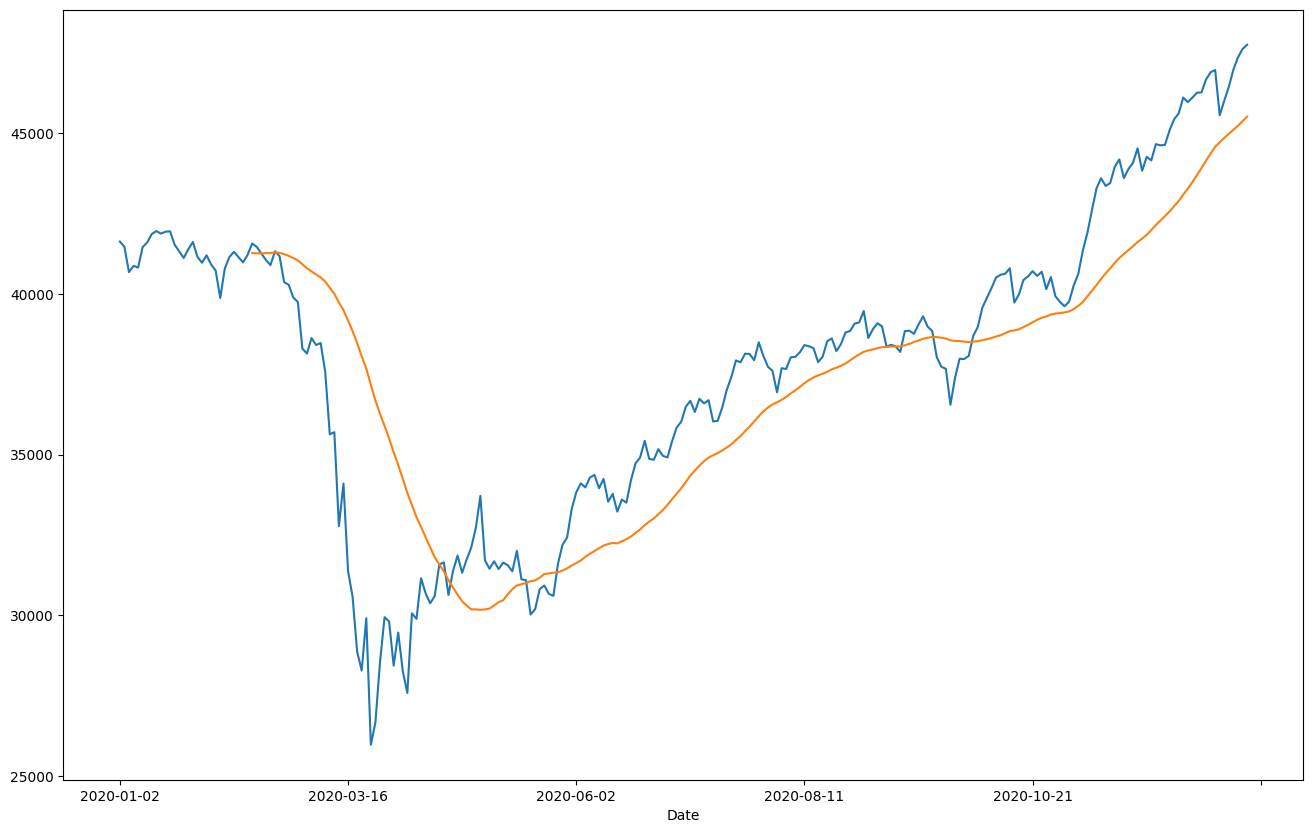

In [23]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [24]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-01-02,41626.640625,-0.9997,0.125,0.796,0.079,41340.269531,41649.289062,41328.449219,5300.0
2020-01-03,41464.609375,-0.9963,0.103,0.805,0.092,41634.511719,41636.179688,41348.679688,8900.0
2020-01-06,40676.628906,-0.9996,0.104,0.839,0.057,41378.339844,41378.339844,40613.960938,8700.0
2020-01-07,40869.468750,-1.0000,0.186,0.745,0.069,40983.039062,41230.140625,40727.371094,11900.0
2020-01-08,40817.738281,-0.9999,0.136,0.799,0.065,40574.828125,40866.359375,40476.550781,18200.0
...,...,...,...,...,...,...,...,...,...
2020-12-23,46444.179688,-0.9996,0.120,0.800,0.080,46072.300781,46513.320312,45899.101562,10500.0
2020-12-24,46973.539062,-0.9971,0.082,0.854,0.064,46743.488281,47053.398438,46539.019531,13700.0
2020-12-28,47353.750000,-0.9997,0.126,0.789,0.085,47153.589844,47406.718750,47148.238281,9600.0


## Data Preparation for Modelling

In [26]:

# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)
     

Number of records in Training Data: 197
Number of records in Test Data: 51


In [27]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2020-01-03    41464.609375
2020-01-06    40676.628906
2020-01-07    40869.468750
2020-01-08    40817.738281
2020-01-09    41452.351562
                  ...     
2020-12-23    46444.179688
2020-12-24    46973.539062
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
Name: Close, Length: 247, dtype: float64

In [28]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-01-03,41464.609375,40676.628906,-0.9963,-0.9996,8900.0,41634.511719,41636.179688,41348.679688
2020-01-06,40676.628906,40869.468750,-0.9996,-1.0000,8700.0,41378.339844,41378.339844,40613.960938
2020-01-07,40869.468750,40817.738281,-1.0000,-0.9999,11900.0,40983.039062,41230.140625,40727.371094
2020-01-08,40817.738281,41452.351562,-0.9999,-0.9997,18200.0,40574.828125,40866.359375,40476.550781
2020-01-09,41452.351562,41599.718750,-0.9997,-0.9999,7800.0,41216.671875,41482.121094,41175.718750
2020-01-10,41599.718750,41859.691406,-0.9999,-0.9998,13200.0,41568.199219,41775.109375,41447.800781
2020-01-13,41859.691406,41952.628906,-0.9998,-0.9999,10600.0,41788.210938,41899.628906,41720.761719
2020-01-14,41952.628906,41872.730469,-0.9999,-0.9998,14100.0,41883.089844,41994.261719,41770.898438
2020-01-15,41872.730469,41932.558594,-0.9998,-0.9998,6100.0,41969.859375,41969.859375,41648.109375


## Setting the Target Variable and the Feature Dataset

In [29]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y


Date
2020-01-03    40676.628906
2020-01-06    40869.468750
2020-01-07    40817.738281
2020-01-08    41452.351562
2020-01-09    41599.718750
                  ...     
2020-12-22    46444.179688
2020-12-23    46973.539062
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
Name: close_price_shifted, Length: 246, dtype: float64

In [30]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2020-01-03,41464.609375,-0.9963,-0.9996,8900.0,41634.511719,41636.179688,41348.679688
2020-01-06,40676.628906,-0.9996,-1.0000,8700.0,41378.339844,41378.339844,40613.960938
2020-01-07,40869.468750,-1.0000,-0.9999,11900.0,40983.039062,41230.140625,40727.371094
2020-01-08,40817.738281,-0.9999,-0.9997,18200.0,40574.828125,40866.359375,40476.550781
2020-01-09,41452.351562,-0.9997,-0.9999,7800.0,41216.671875,41482.121094,41175.718750
...,...,...,...,...,...,...,...
2020-12-22,46006.691406,-0.9999,-0.9996,25100.0,45529.609375,46080.179688,45112.191406
2020-12-23,46444.179688,-0.9996,-0.9971,10500.0,46072.300781,46513.320312,45899.101562
2020-12-24,46973.539062,-0.9971,-0.9997,13700.0,46743.488281,47053.398438,46539.019531


## Scaling the Target Variable and the Feature Dataset

Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [31]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 0.43153524, -0.99629518, -0.99959948, ...,  0.44368178,
          0.3997169 ,  0.44637303],
        [ 0.35868147, -0.99959948, -1.        , ...,  0.41924584,
          0.37425335,  0.37872871],
        [ 0.37651073, -1.        , -0.99989987, ...,  0.38153855,
          0.35961761,  0.38917019],
        ...,
        [ 0.94087058, -0.99709623, -0.99969961, ...,  0.93102119,
          0.93470643,  0.92423892],
        [ 0.97602348, -0.99969961, -0.99979974, ...,  0.97014031,
          0.96959936,  0.98032867],
        [ 1.        , -0.99979974, -0.99979974, ...,  1.        ,
          1.        ,  1.        ]]),
 array([[ 0.35037015],
        [ 0.36809035],
        [ 0.3633368 ],
        [ 0.42165188],
        [ 0.43519356],
        [ 0.45908264],
        [ 0.46762274],
        [ 0.46028081],
        [ 0.46577846],
        [ 0.46695581],
        [ 0.42868691],
        [ 0.40983997],
        [ 0.39068721],
        [ 0.4155914 ],
        [ 0.43643157],
        [ 0.39433915],
     

## Dividing the dataset into Training and Test

Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [32]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (197, 7) and y: (197, 1)
Number of rows and columns in the Test set X: (48, 7) and y: (48, 1)


## Reshaping the Feature Dataset

In [33]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (197, 7, 1)
Shape of Test set X: (48, 7, 1)


## Stock Data Modelling

In [34]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [35]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
16/16 [==============================] - 13s 113ms/step - loss: 0.1474 - val_loss: 0.0699
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.1100 - val_loss: 0.0807
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0489 - val_loss: 0.0340
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0272 - val_loss: 0.0108
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0145 - val_loss: 0.0018
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0116 - val_loss: 0.0022
Epoch 7/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0104 - val_loss: 0.0020
Epoch 8/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0100 - val_loss: 0.0047
Epoch 9/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0123 - val_loss: 0.0040
Epoch 10/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0096 - val_loss: 0.0021
Epoch 1

In [36]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


## Predictions

In [37]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

2/2 [==============================] - 2s 8ms/step
Predictions:


array([[40206.43 ],
       [40518.4  ],
       [40276.727],
       [40388.992],
       [39829.43 ]], dtype=float32)

## Model Evaluation

In [38]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

48/48 [==============================] - 0s 5ms/step - loss: 0.0284
Train Loss = 0.0056
Test Loss = 0.0284


In [39]:

# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 44211.6969


In [40]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 44211.6969


## Plotting the Predictions against unseen data

In [41]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))
     

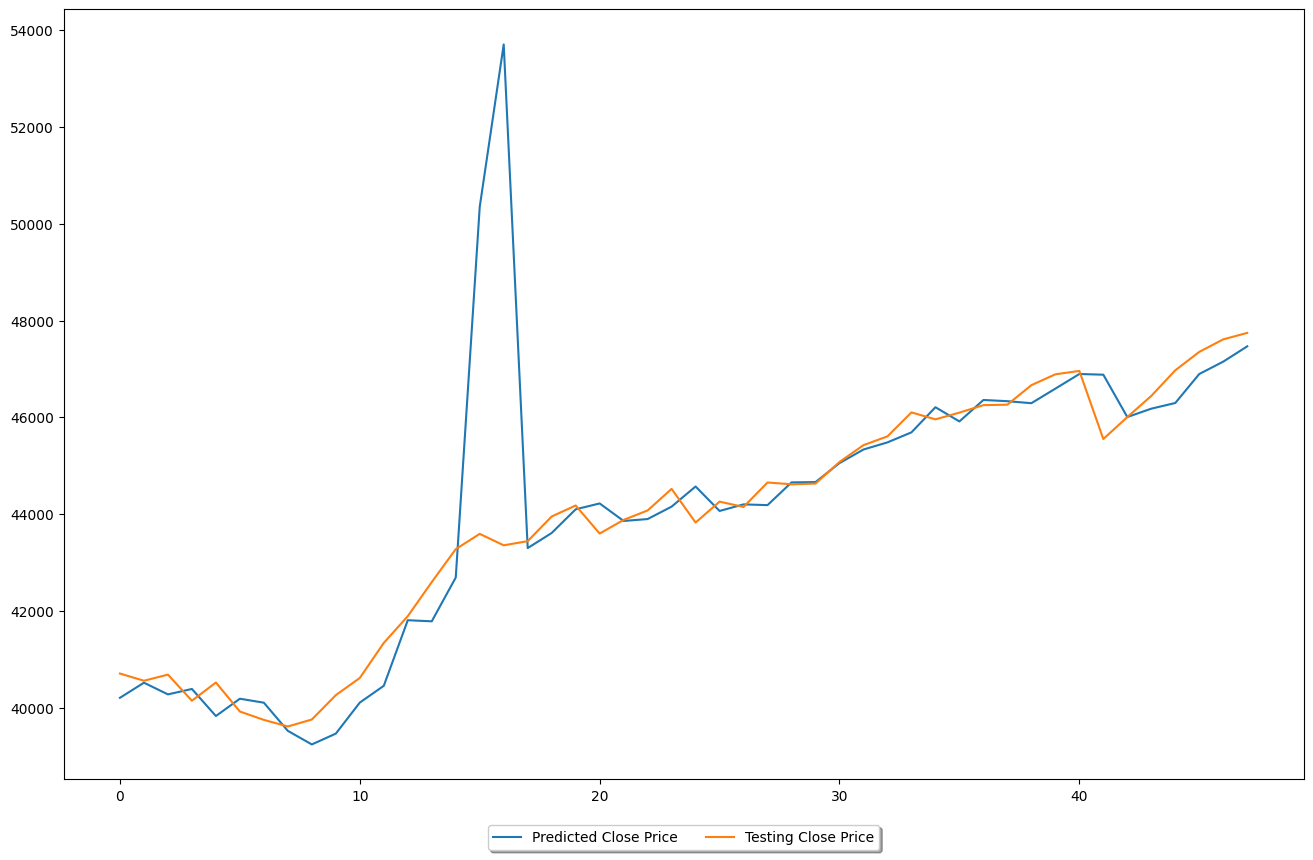

In [42]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

# THANK YOU